# Mapping the seasonal changes to the open water extent of Lake Chad

* **Products used:** 
[wofs_ls](https://explorer.digitalearth.africa/products/wofs_ls)



## Background

A couple of very instructive papers on Lake Chad

- [The Lake Chad hydrology under current climate change](https://www.nature.com/articles/s41598-020-62417-w)
- [Recent Surface Water Extent of Lake Chad from Multispectral Sensors and GRACE](https://www.mdpi.com/1424-8220/18/7/2082)

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 


### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import sys
import xarray as xr
import geopandas as gpd

from IPython.display import Image
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from odc.ui import image_aspect
from datacube.utils import geometry, masking
from datacube.utils.cog import write_cog

from deafrica_tools.datahandling import load_ard, wofs_fuser
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import map_shapefile
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.spatial import xr_rasterize, xr_vectorize

from datacube.utils.aws import configure_s3_access
configure_s3_access(aws_unsigned=True, cloud_defaults=True)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Set up a Dask cluster

Dask can be used to better manage memory use and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/06_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/06_Parallel_processing_with_dask.ipynb).

To activate Dask, set up the local computing cluster using the cell below.

In [2]:
create_local_dask_cluster(n_workers=1)

Client Scheduler: tcp://127.0.0.1:36059 Dashboard: /user/fang.yuan@ga.gov.au/proxy/8787/status,Cluster Workers: 1 Cores: 15 Memory: 104.37 GB


## Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis over.

The parameters are:
* `vector_file`: The path to the shapefile or geojson that will define the analysis area of the study
* `products`: The products to load from the datacube, e.g. `'s2_l2a``, or `'ls8_sr'`
* `time_range`: The date range to analyse (e.g. `('2017', '2019')`.
* `measurements`: The spectral bands to load from the satellite product. `MNDWI` requires the `'green'` and `'swir_1'` bands
* `resolution`: The pixel resolution of the satellite data. `(-30,30)` for Landsat or `(-10,10)` for Sentinel-2
* `dask_chunks`: Chunk sizes to use for dask, the default values below are optimized for the full Okavango delta

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The default area is the Ruko Conservancy. 


In [3]:
vector_file = 'data/lake_chad_extent.geojson'

product = 'wofs_ls'

collection_category = 'T1'

time_range = ('1984', '2022')

resolution = (-30,30)

dask_chunks = {'time':1,'x':1000,'y':1000}

import dask 
dask.config.set(**{'array.slicing.split_large_chunks': True})


## View the Area of Interest on an interative map
The next cell will  first open the vector file and then display the selected area on an interactive map.
Zoom in and out to get a better understanding of the area of interest.

In [4]:
#read shapefile
gdf = gpd.read_file(vector_file)
gdf['id'] = 1

map_shapefile(gdf, attribute='id')

Label(value='')

Map(center=[13.50116392985322, 14.23553466796875], controls=(ZoomControl(options=['position', 'zoom_in_text', …

### Connect to the datacube

Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [5]:
dc = datacube.Datacube(app='water_extent')

## Load cloud-masked Satellite data

The first step is to load satellite data for the specified area of interest and time range. 

In [6]:
bbox=list(gdf.total_bounds)
lon_range = (bbox[0], bbox[2])
lat_range = (bbox[1], bbox[3])

#create the dc query
water_query = {
    'x': lon_range,
    'y': lat_range,
    'time': time_range,
    'resolution': resolution,
    'output_crs': 'EPSG:6933',
    'dask_chunks': dask_chunks,
    'group_by':'solar_day'
              }

Now load the satellite data

In [7]:
wofl = dc.load(product=product, fuse_func=wofs_fuser,
                collection_category=collection_category, **water_query)
print(wofl)

<xarray.Dataset>
Dimensions:      (time: 1712, y: 8056, x: 8127)
Coordinates:
  * time         (time) datetime64[ns] 1984-06-08T08:45:52.291088 ... 2022-08...
  * y            (y) float64 1.827e+06 1.827e+06 ... 1.586e+06 1.586e+06
  * x            (x) float64 1.252e+06 1.252e+06 ... 1.495e+06 1.495e+06
    spatial_ref  int32 6933
Data variables:
    water        (time, y, x) uint8 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


## Resample time series

Due to many factors (e.g. cloud obscuring the region, missed cloud cover in the SCL layer) the data will be gappy and noisy. Here, we will resample the data to ensure we working with a consistent time-series.

To do this we resample the data to seasonal time-steps using medians

These calculations will take **nearly an hour** to complete as we will run `.compute()`, triggering all the tasks we scheduled above and bringing the arrays into memory.

In [8]:
sample_frequency="QS-DEC"  # quarterly starting in DEC, i.e. seasonal

#resample MNDWI using medians
#print('calculating '+wetness_index+' seasonal medians...')
#ds = ds.resample(time='1M', loffset='1M').median().compute()

wet = masking.make_mask(wofl.water, wet=True) 
dry = masking.make_mask(wofl.water, dry=True)
nwet = wet.resample(time=sample_frequency).sum()
ndry = dry.resample(time=sample_frequency).sum()
nobs =nwet+ndry
freq = nwet/nobs

#select use starting month of the quarter/season`
ds_wofs = freq.to_dataset(name='frequency')

In [9]:
#%%time

#ds_wofs = ds_wofs.compute()

In [10]:
ds_wofs

,Array,Chunk
Bytes,80.14 GB,8.00 MB
Shape,"(153, 8056, 8127)","(1, 1000, 1000)"
Count,1952644 Tasks,12393 Chunks
Type,float64,numpy.ndarray


## Mask the satellite data with vector file

In [11]:
#create mask
mask = xr_rasterize(gdf, ds_wofs)

#mask data
ds_wofs = ds_wofs.where(mask)

### Facet plot the water extent for every season

In [12]:
#ds_wofs.frequency.plot.imshow(col='time', col_wrap=4, cmap='RdBu', vmax=1.0, vmin=0);

## Calculate the water extent per time-step

The number of pixels can be used for the area of the waterbody if the pixel area is known. 
Run the following cell to generate the necessary constants for performing this conversion.

In [13]:
pixel_length = water_query["resolution"][1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2

ds_wofs.frequency## Calculating the extent of open water
Calculates the area of pixels classified as water

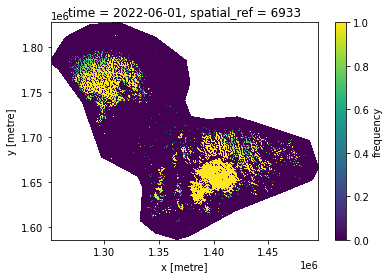

In [14]:
ds_wofs.frequency.isel(time=-1).plot.imshow()

In [15]:
# Excclude incomplete coverage
invalid_frac = np.isnan(ds_wofs.frequency).mean(dim=['x','y']).values


In [16]:
good = invalid_frac< 0.52
good

array([False, False, False, False, False, False, False, False, False,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True, False, False,  True,  True,
        True, False,  True,  True, False, False, False,  True, False,
        True, False,  True, False,  True, False, False, False, False,
       False,  True, False, False,  True, False, False,  True, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [17]:
ds_wofs = ds_wofs.isel(time=good)
ds_valid_water_area = (ds_wofs.frequency > 0.2).sum(dim=['x','y']) * area_per_pixel

In [18]:
%%time

ds_valid_water_area = ds_valid_water_area.compute()

CPU times: user 15min 33s, sys: 21.3 s, total: 15min 54s
Wall time: 32min 26s


In [19]:
ds_valid_water_area

<xarray.DataArray 'frequency' (time: 57)>
array([2057.4504, 3318.8418, 4565.0835, 4300.9416, 3415.9023, 5804.082 ,
       4103.2422, 3332.7846, 4455.1701, 2501.1747, 3097.692 , 4070.1861,
       2350.5471, 3434.2893, 2597.958 , 4150.3842, 2935.8684, 3090.8043,
       2207.8098, 3510.2187, 3303.4662, 4051.9962, 5184.0144, 3705.5196,
       3024.6345, 3716.2467, 6169.5729, 3599.3772, 3347.6733, 3857.13  ,
       4484.0097, 2559.1185, 2439.0216, 3188.1042, 4505.0184, 2866.7916,
       2367.4077, 3332.88  , 5038.8318, 2987.388 , 2566.7001, 3229.4943,
       5216.1021, 2942.6841, 2596.6863, 3382.0659, 6363.36  , 4196.1402,
       3908.1474, 4854.2256, 5606.055 , 5232.0321, 4687.0812, 5417.343 ,
       6292.8207, 4857.7995, 4399.9749])
Coordinates:
  * time         (time) datetime64[ns] 1986-09-01 1986-12-01 ... 2022-06-01
    spatial_ref  int32 6933

### Export time-series as csv

In [20]:
ds_valid_water_area.to_dataframe().drop('spatial_ref',axis=1).rename({'frequency':'Area of waterbodies (km2)'},axis=1).to_csv(f'results/water_extent_{time_range[0]}_to_{time_range[1]}.csv')

### Plot a time series of open water area

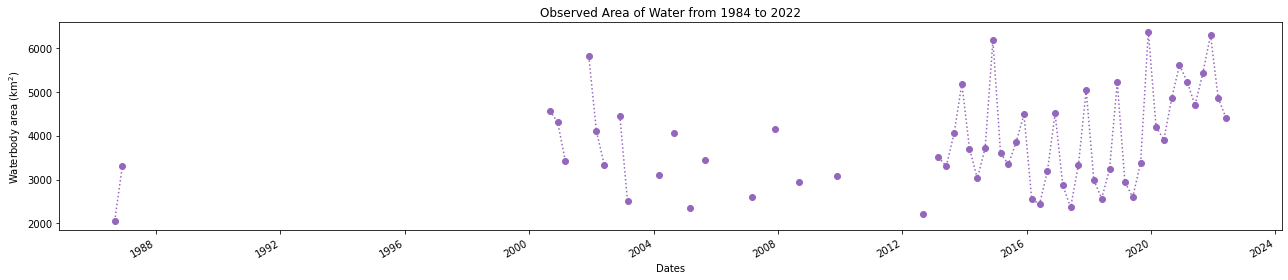

In [74]:
plt.figure(figsize=(18, 4))
ds_valid_water_area.resample(time='QS-DEC').mean().plot(marker='o', color='#9467bd', linestyle=':')
plt.title(f'Observed Area of Water from {time_range[0]} to {time_range[1]}')
plt.xlabel('Dates')
plt.ylabel('Waterbody area (km$^2$)')
plt.tight_layout()
plt.savefig(f'results/water_extent_{time_range[0]}_to_{time_range[1]}.png')

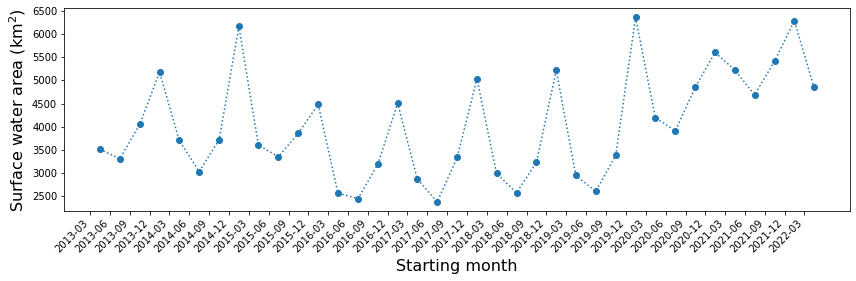

In [159]:
subset = ds_valid_water_area.resample(time='QS-DEC').mean().sel(time=slice('2013','2022-05'))

plt.figure(figsize=(12, 4))
subset.resample(time='QS-DEC', loffset='45D').mean().plot(marker='o', linestyle=':')
plt.title('')
plt.xlabel('Starting month', size=16)
plt.xticks(subset.time.values, labels=subset.time.values.astype('datetime64[M]').astype(str), rotation=45)
plt.ylabel('Surface water area (km$^2$)', size=16)
plt.tight_layout()
plt.savefig(f'results/lake_chad_extent_{subset.time.values.astype("datetime64[M]").astype(str)[0]}_{subset.time.values.astype("datetime64[M]").astype(str)[-1]}.jpg')

## Rainfall

In [98]:
ds_rf_month = dc.load(product='rainfall_chirps_monthly',
                time=('2013-03','2022-06'),
                y = lat_range,
                x = lon_range)

In [100]:
# set -9999 no-data values to NaN
ds_rf_month = ds_rf_month.where(ds_rf_month !=-9999.)


In [102]:
rf_mask = xr_rasterize(gdf, ds_rf_month)
ds_rf_month = ds_rf_month.where(rf_mask)

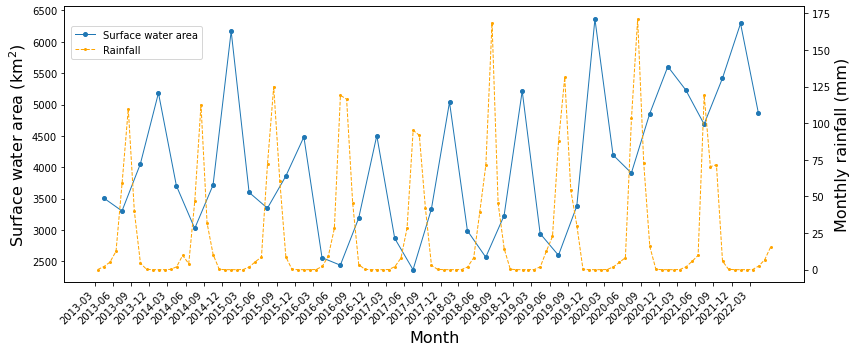

In [163]:
# plot daily total precipitation for this area

fig, ax1 = plt.subplots(figsize=(12,5))

subset.resample(time='QS-DEC', loffset='45D').mean().plot(marker='o', markersize=4, linewidth=1, ax=ax1, label='Surface water area')
ax1.set_title('')
plt.xticks(subset.time.values, labels=subset.time.values.astype('datetime64[M]').astype(str), rotation=45)
plt.xlabel('Month', size=16)
plt.ylabel('Surface water area (km$^2$)', size=16)
#plt.yticks(color='red')

ax2 = ax1.twinx()
#plt.ylabel('%s (%s)'%('Total Precipitation', 'mm'));
ds_rf_month.rainfall.mean(dim=['latitude','longitude']).plot(marker='.', markersize=4, linewidth=1, ax=ax2, linestyle='dashed', color='orange',
                                    label='Rainfall');
plt.ylabel('Monthly rainfall (mm)', size=16)

plt.xticks(subset.time.values, labels=subset.time.values.astype('datetime64[M]').astype(str), rotation=45)
plt.xlabel('Month', size=16)

fig.legend(loc='upper left', bbox_to_anchor=(0.08, 0.93), fontsize=10)
#plt.title(f'Evolution of Lake surface area, compared to catchment rainfall (CHIRPS) over time')
plt.title('')
plt.tight_layout()
plt.savefig('results/lake_chad_extent_vs_rainfall.jpg')